In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
from matplotlib import pyplot as plt
from scipy import interpolate

In [2]:
data = pd.read_csv("./worldcup_scores.csv")

## Total

In [3]:
all_scores = []

all_scores.extend( data['GOALS_1'] )
all_scores.extend( data['GOALS_2'] )
all_scores = np.array(all_scores)

In [4]:
def simulate_poisson(counts, title, N=None):
    '''
    input:
        counts: numpy array for number of goals
        title: str for the plot title and the filename
        N: summary above N-1 goals for calculating chi-squres. if N is None, use all bins separately
    return:
        save the plot
    '''
    mu = np.mean(counts)
    max_v = np.max(counts)
    max_freq = np.max( np.bincount(counts) )
    sigma = sp.sqrt(mu)
    mu_plus_sigma = mu + sigma

    # Bins for the histogram: [0,1), [1, 2), ..., [max(counts), max(counts)+1]
    bins = range(0, max(counts)+2)

    # Histogram
    plt.hist(counts, bins=bins, align="left", histtype="step", color="black")

    # Create Poisson distribution for given mu and do chisqured test
    x = range(0, max_v+1)
    prob = stats.poisson.pmf(x, mu)*len(counts)
    if not N:
        # Use all bins
        chisq, p_value = stats.chisquare(
            np.bincount(counts)
            , prob
            , len(x) - 1 - 1
        )
    elif N:
        # Summarize above N goals bins
        chisq, p_value = stats.chisquare(
            list(np.bincount(counts))[0:N] + [sum(list(np.bincount(counts))[N:])]
            , list(prob[0:N]) + [sum(prob[N:])]
            , N -1
        )

    # Plot the PMF.
    plt.plot(x, prob, "o", color="blue")

    # Draw a smooth curve through the PMF.
    l = sp.linspace(0,max_v,len(counts))
    s = interpolate.spline(x, prob, l)
    plt.plot(l,s,color="blue")

    plt.xlabel("Number of goals for one team")
    plt.ylabel("Number of occurrences (Poisson)")

    # Interpolated probability at x = μ + σ; for marking σ in the graph.
    xx = sp.searchsorted(l,mu_plus_sigma) - 1
    v = ((s[xx+1] -  s[xx])/(l[xx+1]-l[xx])) * (mu_plus_sigma - l[xx])
    v += s[xx]

    ax = plt.gca()
    # Reset axis range and ticks.
    ax.axis([-0.5,max_v+1, 0, max_freq])
    ax.set_xticks(range(1,max_v+1))
    ax.set_yticks(range(0,int(max( max_freq, max(prob))*1.2), max(max_freq // 10,1)))

    # Draw arrow and then place an opaque box with μ in it.
    ax.annotate("", xy=(mu,max_freq // 1.05), xycoords="data", xytext=(mu, 0),textcoords="data", arrowprops=dict(arrowstyle="->",connectionstyle="arc3"))
    bbox_props = dict(boxstyle="round", fc="w", ec="w")
    ax.text(mu, max_freq // 3, r"$\mu$={}".format(round(mu,2)), va="center", ha="center",size=15, bbox=bbox_props)

    # Draw arrow and then place an opaque box with σ in it.
    ax.annotate("", xy=(mu,v), xytext=(mu_plus_sigma,v),arrowprops=dict(arrowstyle="<->", connectionstyle="arc3"))
    bbox_props = dict(boxstyle="round", fc="w", ec="w")
    ax.text(mu+(sigma/2.0), v, r"$\sigma$", va="center", ha="center",size=15, bbox=bbox_props)

    # Refresh plot and save figure.
    plt.title("{}, p-value: %.4g".format(title)%p_value)
    plt.draw()
    plt.savefig("./result_each_team/{}.png".format(title), dpi=500)

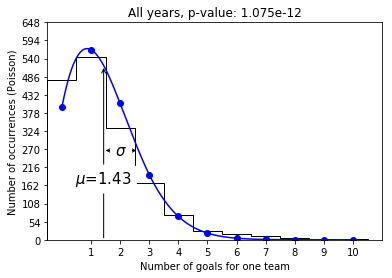

In [5]:
simulate_poisson(all_scores,"All years", N=4)

## Each year

In [6]:
%%time

EACH_YEAR = np.unique( data['YEAR'] )

for e in EACH_YEAR:
    each_year_data = data[ data['YEAR'] == e ]

    each_year_score = []
    each_year_score.extend(each_year_data['GOALS_1'])
    each_year_score.extend(each_year_data['GOALS_2'])
    
    simulate_poisson(each_year_score, str(e), N=4)
    plt.close()

CPU times: user 23.9 s, sys: 318 ms, total: 24.2 s
Wall time: 24.6 s
